In [177]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

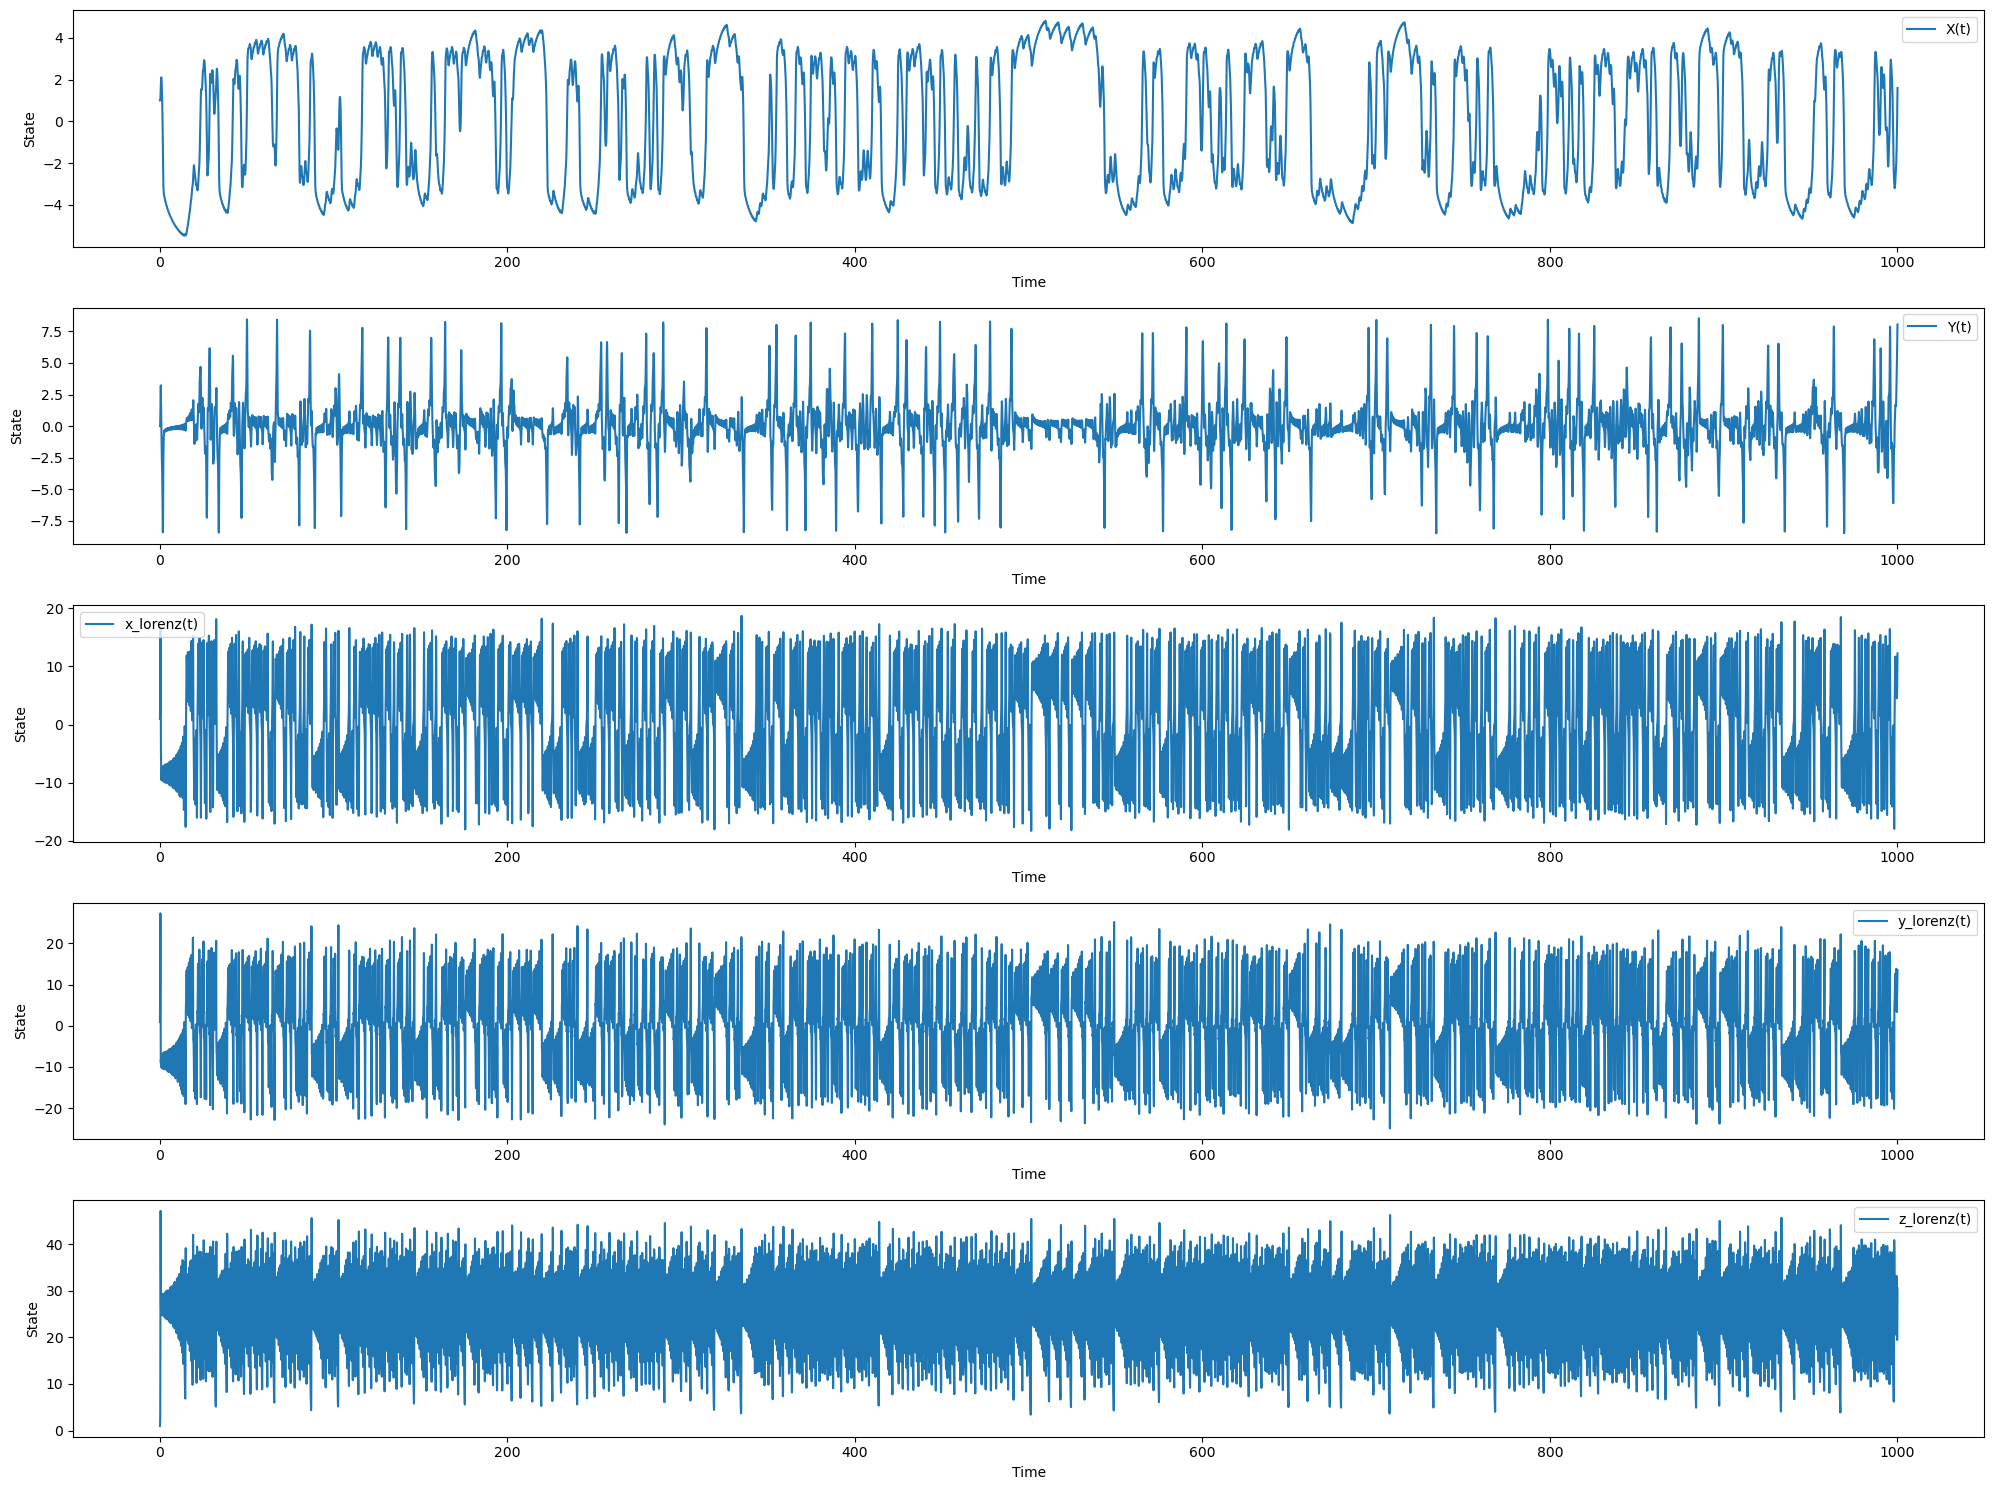

In [178]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 1000)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 10000))

# Plot the results
plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
plt.plot(sol.t, sol.y[0], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t, sol.y[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sol.t, sol.y[2], label='x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sol.t, sol.y[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(sol.t, sol.y[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

In [179]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'Time': sol.t,
    'X': sol.y[0],
    'x_lorenz': sol.y[2]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [180]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [181]:
X = data.values

In [182]:
X.shape

(10000, 3)

In [183]:
X[-10:]

array([[ 9.99099910e+02, -2.31253675e+00,  5.38994685e+00],
       [ 9.99199920e+02, -2.14587431e+00,  7.75257764e+00],
       [ 9.99299930e+02, -1.94429815e+00,  1.10682181e+01],
       [ 9.99399940e+02, -1.67818817e+00,  1.16755043e+01],
       [ 9.99499950e+02, -1.33601027e+00,  8.19338418e+00],
       [ 9.99599960e+02, -9.26812816e-01,  5.14195588e+00],
       [ 9.99699970e+02, -4.48701628e-01,  4.52916643e+00],
       [ 9.99799980e+02,  1.21129191e-01,  5.96858509e+00],
       [ 9.99899990e+02,  8.08096259e-01,  9.18481031e+00],
       [ 1.00000000e+03,  1.59463216e+00,  1.22604653e+01]])

In [184]:
def plot_vanderpol_2d(X, timesteps):
    # 2D プロットの作成
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Van Der Pol Oscillator (t/x plane)")
    ax.set_xlabel("t")
    ax.set_ylabel("x")

    # 軌跡の描画
    for i in range(timesteps-1):
        ax.plot(X[i:i+2, 0], X[i:i+2, 1], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

    plt.show()


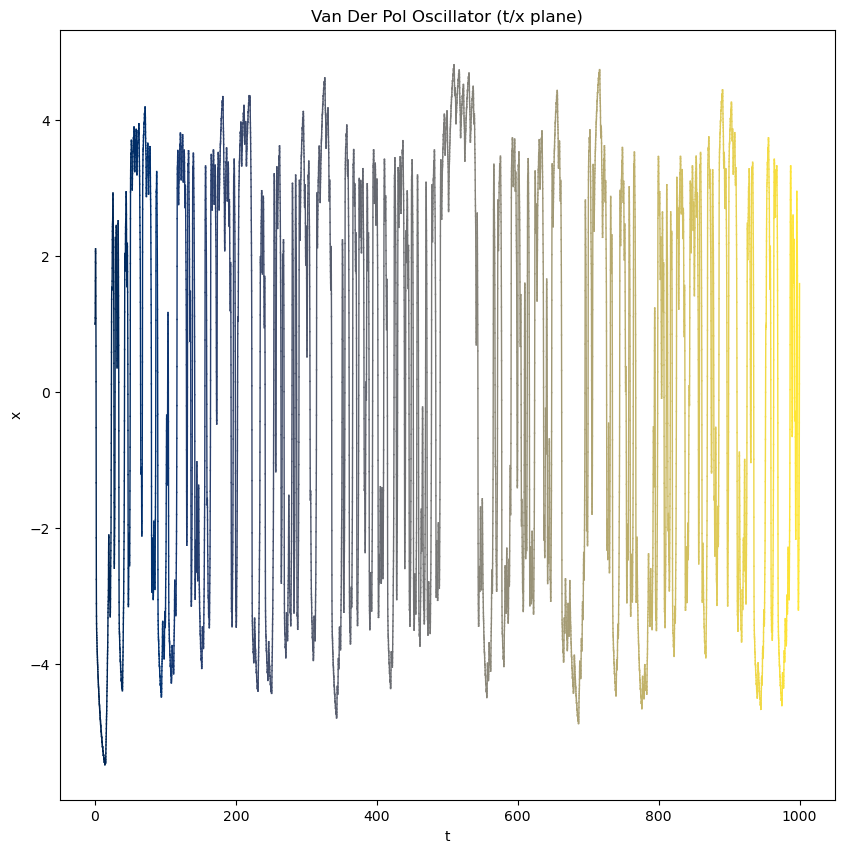

In [185]:
plot_vanderpol_2d(X, 10000)

# 最適化をする前に、一度esnをfittingさせてみる。

In [186]:
X = X[:, 1]

#z-score normalizationを施す。
X = (X - np.mean(X)) / np.std(X) 

In [187]:
X = X.reshape(-1, 1)
X.shape

(10000, 1)

In [188]:
X

array([[0.32261709],
       [0.3229254 ],
       [0.32770749],
       ...,
       [0.03927255],
       [0.26074807],
       [0.51432419]])

In [189]:
from reservoirpy.datasets import to_forecasting

#1期先の予測を行う。
X, Y = to_forecasting(X, forecast=1)
X_train1, Y_train1 = X[:1000], Y[:1000]
X_test1, Y_test1 = X[1000:], Y[1000:]

In [190]:
#仮にパラメータを設定する。
units = 500
leak_rate = 0.17113764962939737
spectral_radius = 1.182082887824895
input_scaling = 0.9697295578201843
connectivity = 0.10407566959031667      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 5.602814683095597e-09
seed = 1234             # for reproducibility

In [191]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [192]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [193]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [194]:
np.all(readout.Wout == 0.0)

True

In [195]:
esn = esn.fit(X_train1, Y_train1, warmup=100)

In [196]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

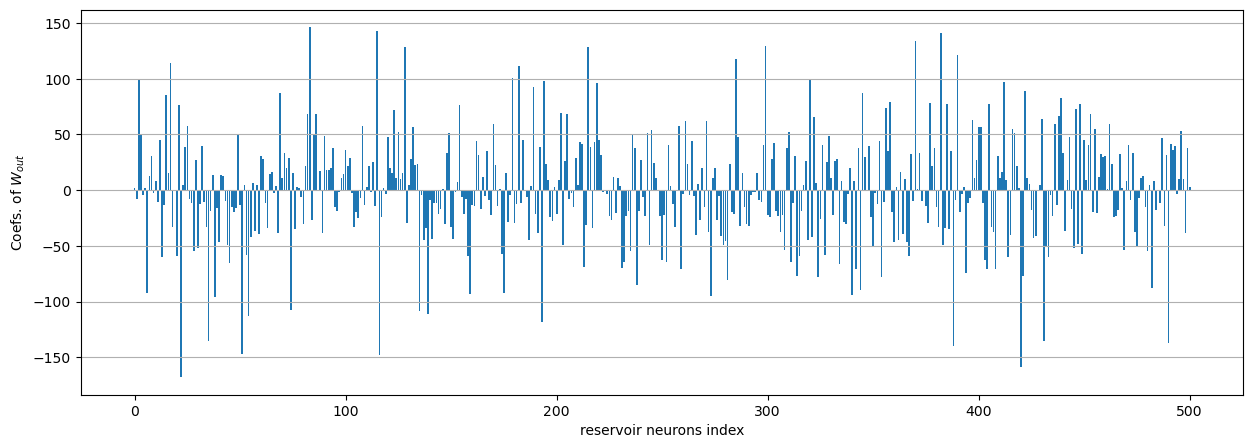

In [197]:
plot_readout(readout)

In [198]:
def plot_results(y_pred, y_test, sample=1000):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [199]:
Y_pred1 = esn.run(X_test1)

In [200]:
Y_test1

array([[-1.02454365],
       [-0.97350789],
       [-0.92445228],
       ...,
       [ 0.03927255],
       [ 0.26074807],
       [ 0.51432419]])

# 最適化をしない状態で一期先の予測に対してRCを用いてみた結果が下である。

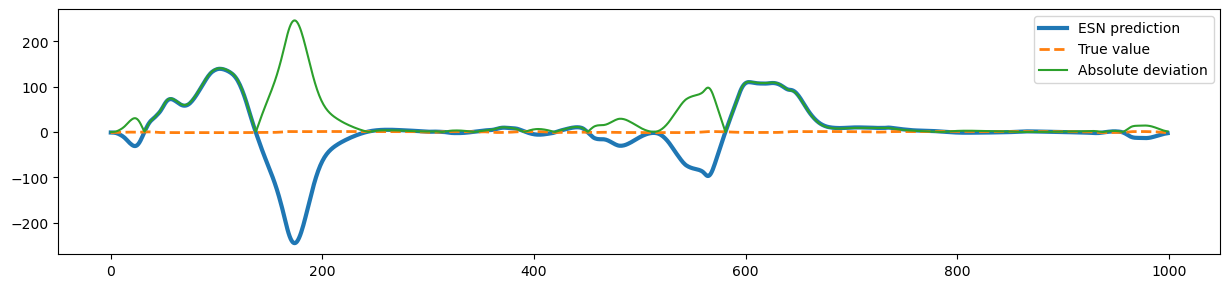

In [201]:
plot_results(Y_pred1, Y_test1)

In [202]:
rsquare(Y_test1, Y_pred1), nrmse(Y_test1, Y_pred1)

(-2102.3865272720186, 14.545452155873795)

# nrmseで14.545452155873795

## 次に、最適化を試みる。最適化するのは、spectral_radius, leak_rate, input_scaling, regularization, connectivity.
10期先を予測する。

In [203]:
def objective(dataset, config, *, cell_number, leak_rate, spectral_radius, input_connectivity, input_scaling, connectivity, regularization, seed):
    
    X, Y = to_forecasting(dataset, forecast=1)
    X_train1, Y_train1 = X[:1000], Y[:1000]
    X_test1, Y_test1 = X[1000:], Y[1000:]
    
    instances = config["instances_per_trial"]

    variable_seed = seed 
        
    losses = []; r2s = [];
    for n in range(instances):
        reservoir = Reservoir(cell_number, input_scaling=input_scaling, sr=spectral_radius,
                        lr=leak_rate, rc_connectivity=connectivity, 
                        input_connectivity=input_connectivity, seed=seed)

        readout   = Ridge(1, ridge=regularization)

        esn = reservoir >> readout
            
        esn = esn.fit(X_train1, Y_train1, warmup=100)
        
        Y_pred1 = esn.run(X_test1)
        
        loss = nrmse(Y_test1, Y_pred1)
        r2 = rsquare(Y_test1, Y_pred1)
        
        losses.append(loss)
        r2s.append(r2)
        
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [204]:
hyperopt_config = {
    "exp": f"hyperopt-MG-onestep-prediction", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "cell_number": ["choice", 500],             # the number of neurons is fixed to 500
        "spectral_radius": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "leak_rate": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "input_connectivity": ["choice", 0.2], # the number of neurons is fixed to 0.2
        "regularization": ["loguniform", 1e-10, 1],  # the regularization parameter is log-uniformly distributed between 1e-10 and 1.
        "connectivity": ["uniform", 0, 1], # the connectivity of the random network in the hidden layer uniformly distributed between 0 and 1.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [205]:
from reservoirpy.hyper import research

best = research(objective, X, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [22:11<00:00,  6.66s/trial, best loss: 0.0018013801389398425]


In [206]:
best

({'cell_number': 0,
  'connectivity': 0.8366729834984419,
  'input_connectivity': 0,
  'input_scaling': 0.15716834911966804,
  'leak_rate': 0.8156304946175557,
  'regularization': 2.1485035108008518e-08,
  'seed': 0,
  'spectral_radius': 1.0385323042151453},
 <hyperopt.base.Trials at 0x28c272cd0>)

# これで最適なhyperparametersが出た。再度esnのfittingを試してみる。

In [207]:
#仮にパラメータを設定する。
units = 500
leak_rate = 0.8156304946175557
spectral_radius = 1.0385323042151453
input_scaling = 0.15716834911966804
connectivity = 0.8366729834984419      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 2.1485035108008518e-08
seed = 1234             # for reproducibility

In [208]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [209]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [210]:
np.all(readout.Wout == 0.0)

True

In [211]:
esn = esn.fit(X_train1, Y_train1, warmup=100)

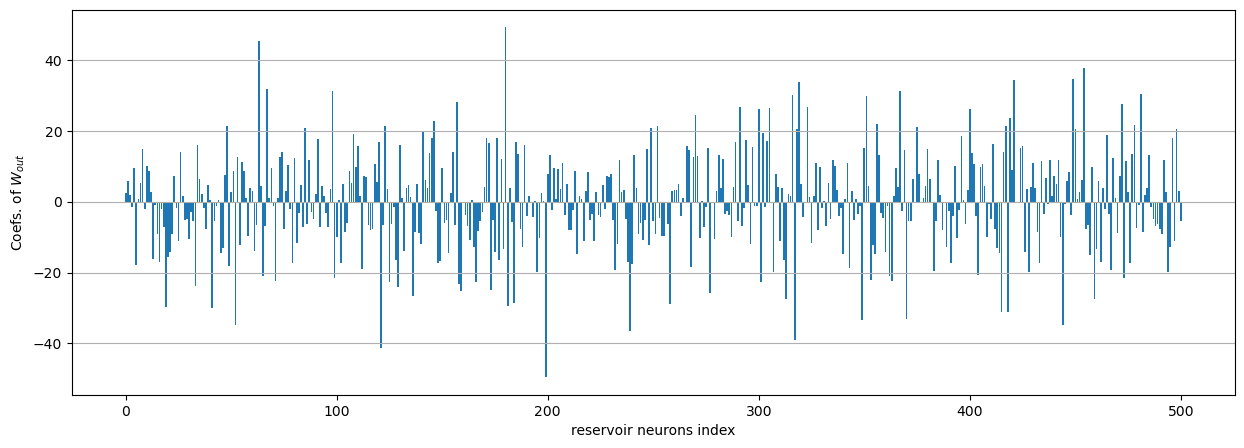

In [212]:
#W_outの成分
plot_readout(readout)

In [213]:
Y_pred1 = esn.run(X_test1)

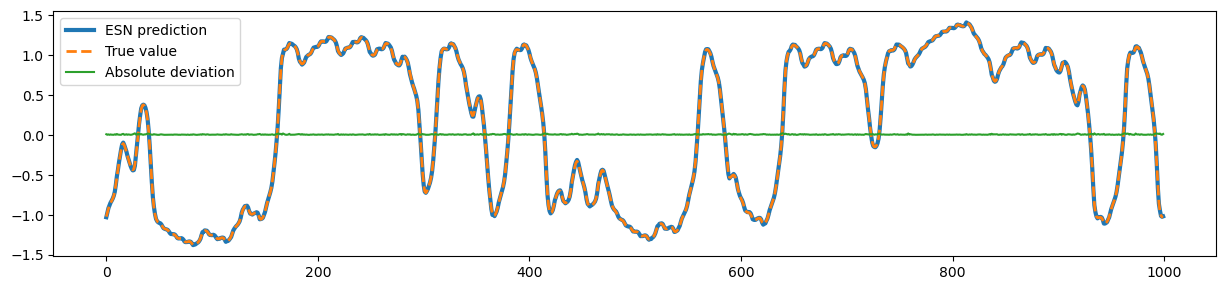

In [214]:
plot_results(Y_pred1, Y_test1)

In [215]:
rsquare(Y_test1, Y_pred1), nrmse(Y_test1, Y_pred1)

(0.9999677303041322, 0.00180162798170903)

# nrmseで0.00180162798170903

# 比べるべきはXとY_pred1でした

In [216]:
X[-9:]

array([[-0.74533189],
       [-0.69160057],
       [-0.6266132 ],
       [-0.54082037],
       [-0.43050355],
       [-0.29857988],
       [-0.14443869],
       [ 0.03927255],
       [ 0.26074807]])

In [217]:
Y_pred1[-10:]

array([[-0.74707953],
       [-0.6945698 ],
       [-0.63311738],
       [-0.54737833],
       [-0.43320449],
       [-0.30150808],
       [-0.15340352],
       [ 0.02702183],
       [ 0.24489332],
       [ 0.50384906]])

In [218]:
X[-10:]

array([[-0.79616095],
       [-0.74533189],
       [-0.69160057],
       [-0.6266132 ],
       [-0.54082037],
       [-0.43050355],
       [-0.29857988],
       [-0.14443869],
       [ 0.03927255],
       [ 0.26074807]])